<a href="https://colab.research.google.com/github/wonyoung-ji/project/blob/master/Goyang_Public_Bicycle/%EA%B3%A0%EC%96%91%EC%8B%9C_%EA%B3%B5%EA%B3%B5%EC%9E%90%EC%A0%84%EA%B1%B0_EDA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 준비

In [ ]:
# 나눔폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 런타임 다시 시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,140 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

## (1) 구글드라이브연동

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# path to your project on Google Drive
from os.path import join  

MY_GOOGLE_DRIVE_PATH = '/content/gdrive/My Drive/Colab Notebooks/고양시/data'
PROJECT_PATH = join('/content/gdrive', MY_GOOGLE_DRIVE_PATH)

%cd "{PROJECT_PATH}"
!ls

/content/gdrive/My Drive/Colab Notebooks/고양시/data
 01.운영이력.csv			     22.주차장정보.csv
 02.자전거스테이션.csv			     23.고양시덕양구_DEM.img
 03.꽃박람회일정.csv			     24.고양시일산동구_DEM.img
 04.KINTEX행사일정.csv			     25.고양시일산서구_DEM.img
 05.기상정보.csv			    '26.고양시 공연장 박물관 정보.csv'
'06.인구(거주)분포도(100M_X_100M).geojson'  '27.고양시 체육시설 현황 정보.csv'
 07.인구통계.csv			     28.코드정의서.xlsx
'08.행정경계(시군구).geojson'		    '29.지하철 역별 이용객수.csv'
'09.행정경계(읍면동).geojson'		     30.고양시_덕양구_고도.geojson
'10.도시계획(공간시설).geojson'		     31.고양시_일산동구_고도.geojson
'11.도시계획(공공문화체육시설).geojson'      32.고양시_일산서구_고도.geojson
'12.도시계획(교통시설).geojson'		     33.고양시_인도.geojson
'13.용도지역지구(습지보호지역).geojson'     '34.행정경계(행정동기준).geojson'
 14.고양시_지적도.geojson		     출퇴근_데이터.

## (2) 패키지 호출

In [ ]:
!pip install geopandas
!pip install geojson
!pip install haversine     # 좌표간 거리 구하기
!pip install tqdm

     |████████████████████████████████| 972kB 2.6MB/s 
     |████████████████████████████████| 14.8MB 295kB/s 
     |████████████████████████████████| 10.9MB 35.0MB/s 


In [ ]:
import json
import pandas as pd
import numpy as np
import geojson
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import missingno as mnso
from shapely.geometry import shape, GeometryCollection, Point
import geopandas as gpd
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# plt 폰트 설정
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

# EDA 1

## (1) 스테이션 위치 시각화

### (1).1 동별 경계 + 스테이션 위치 시각화

- '34.행정경계(행정동기준).geojson' 데이터로 지역을 구분한 후 '02.자전거스테이션.csv'의 스테이션 위치를 확인해본다

In [ ]:
geo_path_34="34.행정경계(행정동기준).geojson"
geo_str_34=geojson.load(open(geo_path_34,encoding='utf-8'))

In [ ]:
df_2 = pd.read_csv('02.자전거스테이션.csv')
df_2.head()

,Station_ID,STATION_NAME,거치대 수량,위도,경도
0,101,어울림마을 701동 앞,20,37.654775,126.834584
1,103,대림e-편한세상106동,20,37.660442,126.840377
2,104,탄현마을8단지,25,37.698523,126.766042
3,105,KT 덕양지사 앞,20,37.655244,126.839261
4,106,원당역 앞 공영주차장,30,37.653410,126.842530


In [ ]:
map_station = folium.Map(location=[df_2['위도'].mean(), df_2['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
folium.GeoJson(geo_str_34).add_to(map_station)

for i, row in station.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=1,
        color='red',
        fill=True,
    ).add_to(map_station)
map_station

- 스테이션의 밀집도를 확인하기 위해 히트맵을 이용한다.

In [ ]:
map_station_heat = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
plugins.HeatMap(station[['위도', '경도']].values.tolist(),
                        radius=10, blur=5
                        ).add_to(map_station_heat)
plugins.Fullscreen(position='topright').add_to(map_station_heat)
map_station_heat

- 유독 두 구역에 밀집도가 높게 표시되는 것을 볼 수 있다.
- 고양시에 전체적으로 스테이션이 위치한 것이 아닌, 어떠한 이유로 인해 특정구역에 밀집하여 위치하고 있다는 것을 알 수 있다.


## (2) 스테이션과 위치 데이터 결합



### (2).1. 동 

- 위에 표시된 스테이션을 범주화 하기위해 '동', '구'별로 분류한다.

In [ ]:
df_2=pd.read_csv('02.자전거스테이션.csv')
df_2.head()

,Station_ID,STATION_NAME,거치대 수량,위도,경도
0,101,어울림마을 701동 앞,20,37.654775,126.834584
1,103,대림e-편한세상106동,20,37.660442,126.840377
2,104,탄현마을8단지,25,37.698523,126.766042
3,105,KT 덕양지사 앞,20,37.655244,126.839261
4,106,원당역 앞 공영주차장,30,37.653410,126.842530


In [ ]:
df_7=pd.read_csv('07.인구통계.csv')

df_7['총인구수']=df_7['총인구수'].str.replace(',', '').astype('float64')
df_7=df_7[df_7['조회기준']=='2019년12월']    # 가장 최신 데이터 사용
df_7=df_7[df_7['총인구수']<=250000]          # 필요없는 데이터 제거
df_7.head()

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
107,경기도 고양시 덕양구 주교동(4128151000),2019년12월,15748.0,"7,362",2.14,"8,126","7,622",1.07
143,경기도 고양시 덕양구 원신동(4128152000),2019년12월,23942.0,"9,419",2.54,"11,568","12,374",0.93
179,경기도 고양시 덕양구 흥도동(4128153000),2019년12월,44565.0,"18,311",2.43,"21,702","22,863",0.95
215,경기도 고양시 덕양구 성사1동(4128154000),2019년12월,22062.0,"9,676",2.28,"10,928","11,134",0.98
251,경기도 고양시 덕양구 성사2동(4128155000),2019년12월,11729.0,"4,783",2.45,"5,689","6,040",0.94


- '02.자전거스테이션.csv' 데이터 셋의 좌표값으로 '34.행정경계(행정동기준).geojson'의 동 좌표와 비교하여 해당 동 출력

In [ ]:
point= [Point(xy) for xy in zip(df_2.경도, df_2.위도)]  # 모든 스테이션의 (경도, 위도)를 가지고 있음

dong=[]
id=[]

for feature in geo_str_34['features']:                      
    polygon = shape(feature['geometry'])               # geostr내의 행정동 좌표값을 각각 가져와서 polygon 형태로 만듦
    for p in range(len(point)):
      if polygon.contains(point[p]):                    # 행정동이 스테이션의 (경도, 위도)를 가지고 있다면
        dong.append(feature['properties']['행정동명'])  # 그 행정동의 이름을 dong에 넣고
        id.append(df_2['Station_ID'][p])                # 스테이션의 이름을 id에 넣음
        
st_d=pd.DataFrame([dong,id])      # 스테이션별 좌표와, 스테이션이 위치한 동의 이름으로 df만듦
st_d=st_d.T
st_d.columns=['dong','Station_ID']
st_d=st_d[['Station_ID','dong']]
st_d.head()

,Station_ID,dong
0,146,주교동
1,170,원신동
2,171,원신동
3,172,원신동
4,173,원신동


### (2).2 구

In [ ]:
df_8=gpd.read_file('08.행정경계(시군구).geojson')
df_8.head()

,SIG_CD,SIG_KOR_NM,geometry
0,41281,고양시덕양구,"MULTIPOLYGON (((126.92910 37.74849, 126.92964 ..."
1,41285,고양시일산동구,"MULTIPOLYGON (((126.77762 37.67899, 126.77825 ..."
2,41287,고양시일산서구,"MULTIPOLYGON (((126.76703 37.70717, 126.76719 ..."


In [ ]:
geo_path_8='08.행정경계(시군구).geojson'
geo_str_8= geojson.load(open(geo_path_8,encoding='utf-8'))

- 위와 같은 방법으로 '08.행정경계(시군구).geojson'의 구 좌표와 비교하여 해당 구 출력

In [ ]:
# 스테이션의 좌표로 '구' 찾기

point= [Point(xy) for xy in zip(df_2.경도, df_2.위도)]  # 모든 스테이션의 (경도, 위도)를 가지고 있음

gu=[]
location=[]
id=[]

for feature in geo_str_8['features']:                      
    polygon = shape(feature['geometry'])               # geostr내의 행정동 좌표값을 각각 가져와서 polygon 형태로 만듦
    for p in range(len(point)):
      if polygon.contains(point[p]):                    # 행정동이 스테이션의 (경도, 위도)를 가지고 있다면
        gu.append(feature['properties']['SIG_KOR_NM'])  # 그 행정구의 이름을 gu에 넣고
        location.append(point[p])                       # 스테이션의 (경도, 위도)를 location에 넣고
        id.append(df_2['Station_ID'][p])                # 스테이션의 이름을 id에 넣음
        
st_g=pd.DataFrame([gu,location,id])      # 스테이션별 좌표와, 스테이션이 위치한 동의 이름으로 df만듦
st_g=st_g.T
st_g.columns=['gu','좌표','Station_ID']
st_g[['Station_ID','좌표','gu']]
st_g=st_g[['Station_ID','gu']]
st_g.head()



,Station_ID,gu
0,101,고양시덕양구
1,103,고양시덕양구
2,105,고양시덕양구
3,106,고양시덕양구
4,110,고양시덕양구


### (2).3 구 + 동 + 스테이션의 위치

- st_d(스테이션+동 데이터), st_g(스테이션+구 데이터)를 '02.자전거스테이션.csv'와 merge

In [ ]:
station=pd.merge(df_2,st_d,on='Station_ID')
station=pd.merge(station,st_g,on='Station_ID')
station=station[['gu','dong','Station_ID','STATION_NAME','거치대 수량','경도','위도']]
station.head()

,gu,dong,Station_ID,STATION_NAME,거치대 수량,경도,위도
0,고양시덕양구,성사2동,101,어울림마을 701동 앞,20,126.834584,37.654775
1,고양시덕양구,성사1동,103,대림e-편한세상106동,20,126.840377,37.660442
2,고양시일산서구,탄현동,104,탄현마을8단지,25,126.766042,37.698523
3,고양시덕양구,성사1동,105,KT 덕양지사 앞,20,126.839261,37.655244
4,고양시덕양구,성사1동,106,원당역 앞 공영주차장,30,126.842530,37.653410


- 해당 데이터는 대부분의 EDA에서 활용하므로 편의를 위해 CSV파일로 저장한다.

In [ ]:
station.to_csv('station.csv')

## (3) 스테이션 개수

- 다음으로 동별, 구별로 스테이션 개수를 살펴본다.

### (3).1 동별 스테이션 개수

In [ ]:
map_dong_count = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=11,tiles='cartodbpositron')

folium.Choropleth(geo_data=geo_str_34,
                  data=station,
                  columns=['dong','거치대 수량'],
                  key_on='feature.properties.행정동명', 
                  fill_color='Blues').add_to(map_dong_count)
map_dong_count

- 동별 스테이션 개수
  - 색이 진할수록 해당 지역에 스테이션 개수가 많다는 뜻이다.

- 보다 정확한 수치로 확인하기 위해 `bar plot`으로 시각화한다.

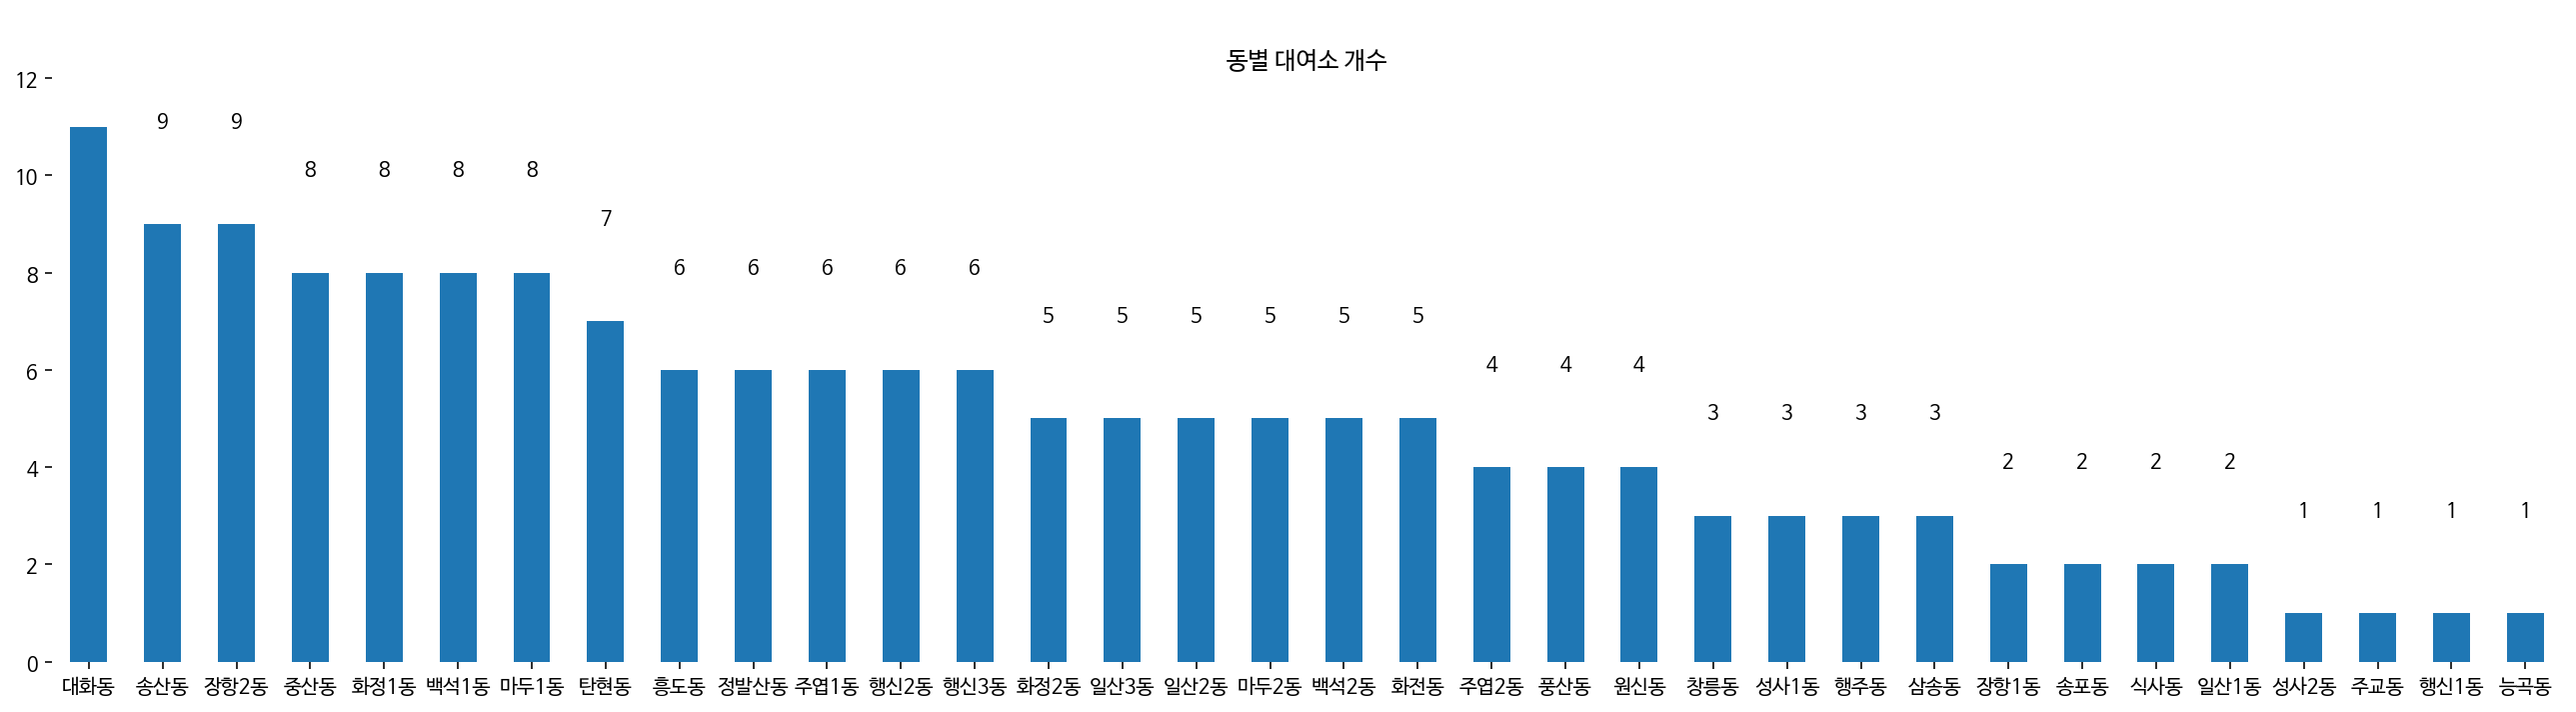

In [ ]:
dong_have_bikes =station.groupby('dong').size()
dong_have_bikes.sort_values(ascending=False, inplace=True)

ax = dong_have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="동별 대여소 개수")
for p in ax.patches: 
     left, bottom, width, height = p.get_bbox().bounds 
     ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.ylim((0,12))
plt.tight_layout()
plt.show()

- 위의 그래프를 통해 다음과 같은 사실을 도출해낼 수 있다.
  - 가장 많은 곳은 [대화동 - 11개]
  - 가장 적은 곳은 [성사2동, 주교동, 행신1동, 능곡동 - 1개]로 분포되어있다.

### (3).2 구별 스테이션 개수

- 구별 스테이션 개수를 확인해본다.
  - 지도로 시각화한 결과 큰 차이점이 없으므로 `bar plot`으로 수치를 확인한다.

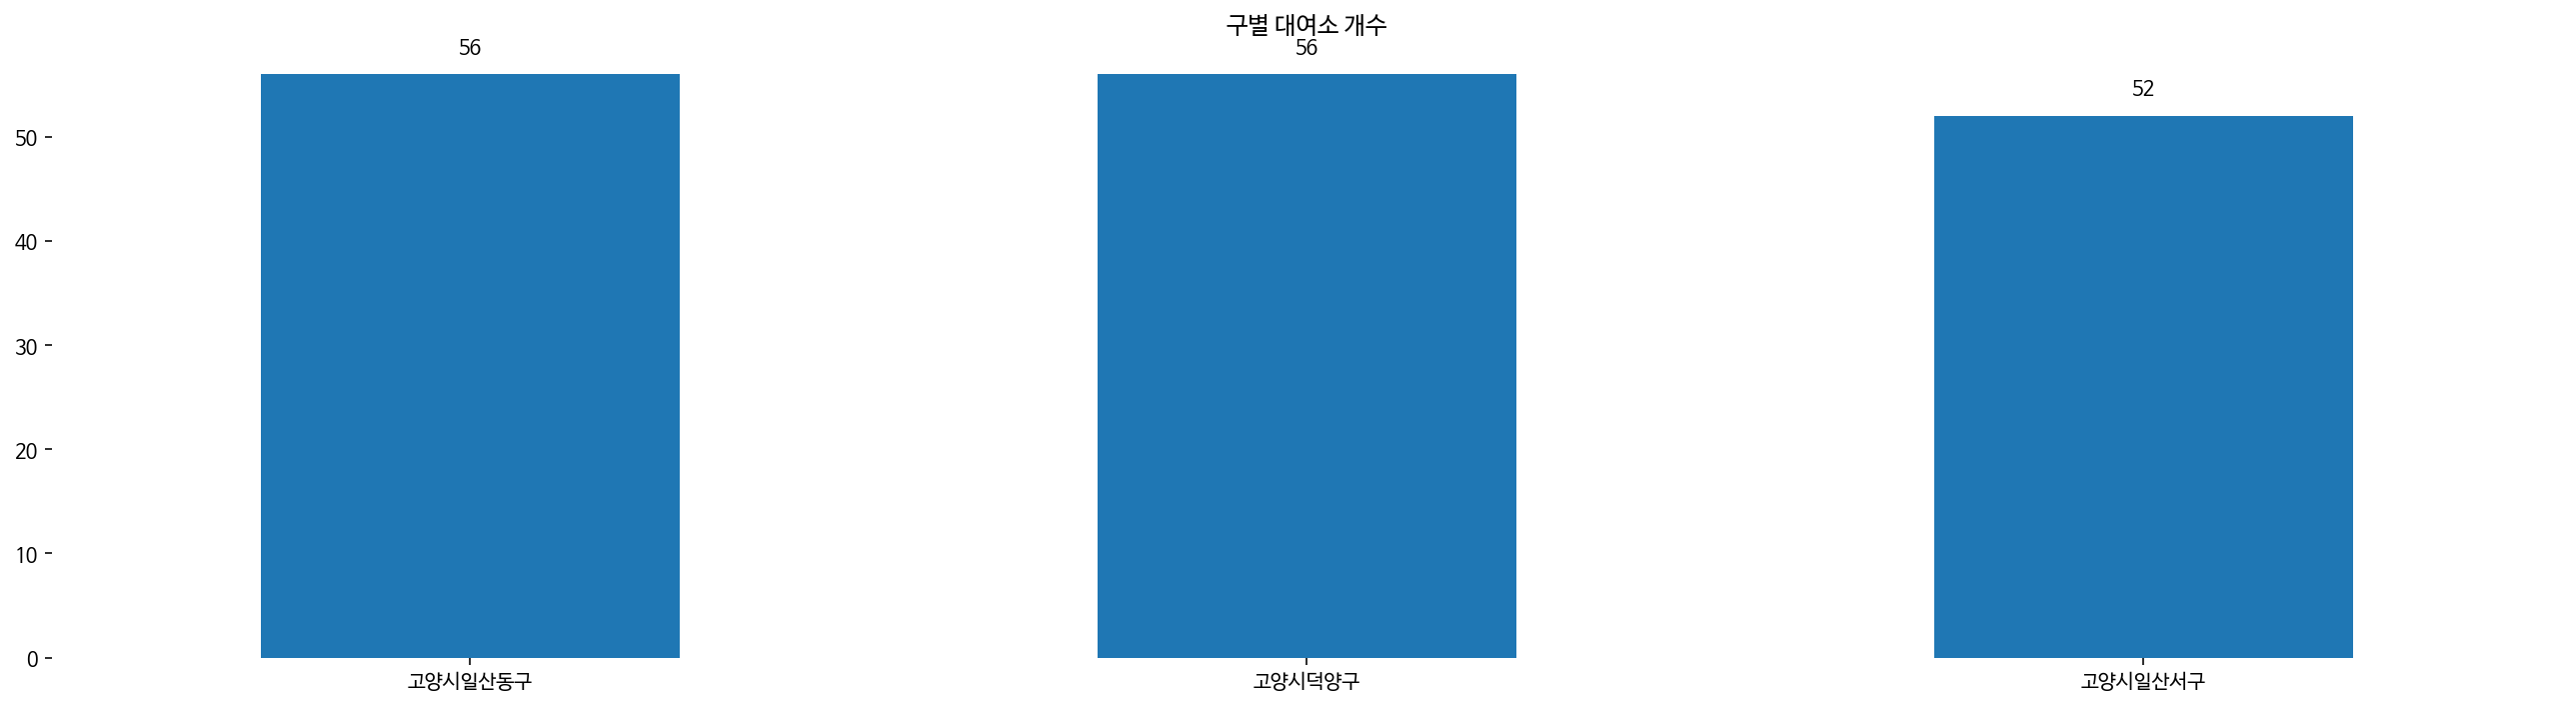

In [ ]:
gu_have_bikes =station.groupby('gu').size()
gu_have_bikes.sort_values(ascending=False, inplace=True)

ax = gu_have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="구별 대여소 개수")
for p in ax.patches: 
     left, bottom, width, height = p.get_bbox().bounds 
     ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

- 대여소 개수가 동별로는 많은 차이를 보였으나, 구별로는 큰 차이가 나지 않는다.


## (4) 스테이션 별 평균 거치대 수

- '02.자전거스테이션' 데이터 중 '거치대 수량' feature가 존재한다.
  - '거치대 수량' : 해당 스테이션별로 자전거를 거치할 수 있는 거치대가 상이하다.
- '거치대 수량'의 분포를 확인한다. 

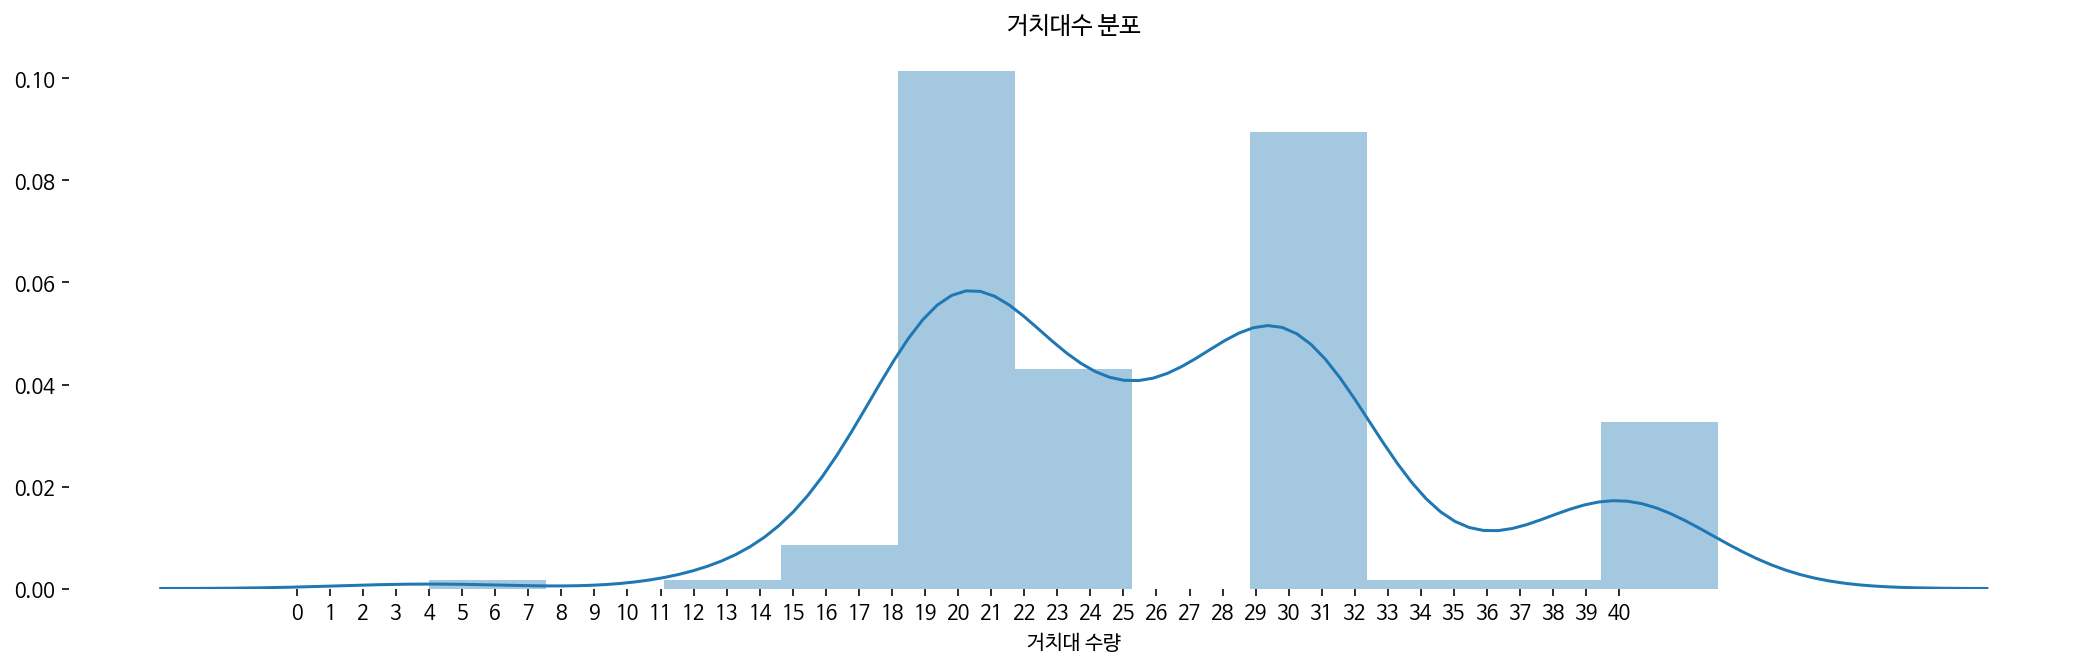

In [ ]:
plt.figure(figsize=(18, 5))
sns.distplot(station['거치대 수량'])
plt.title("거치대수 분포")
plt.xticks(range(0, 41))
plt.box(False)
plt.show()

- 약 40대의 거치대를 보유하고 있는 대형 스테이션이 다소 존재한다.
- 20대, 30대의 거치대를 보유하고있는 스테이션이 가장 많다.


### (4).1 동별 스테이션 별 거치대 수

- 위의 분포를 동별로 범주화하여 구체적으로 살펴본다.

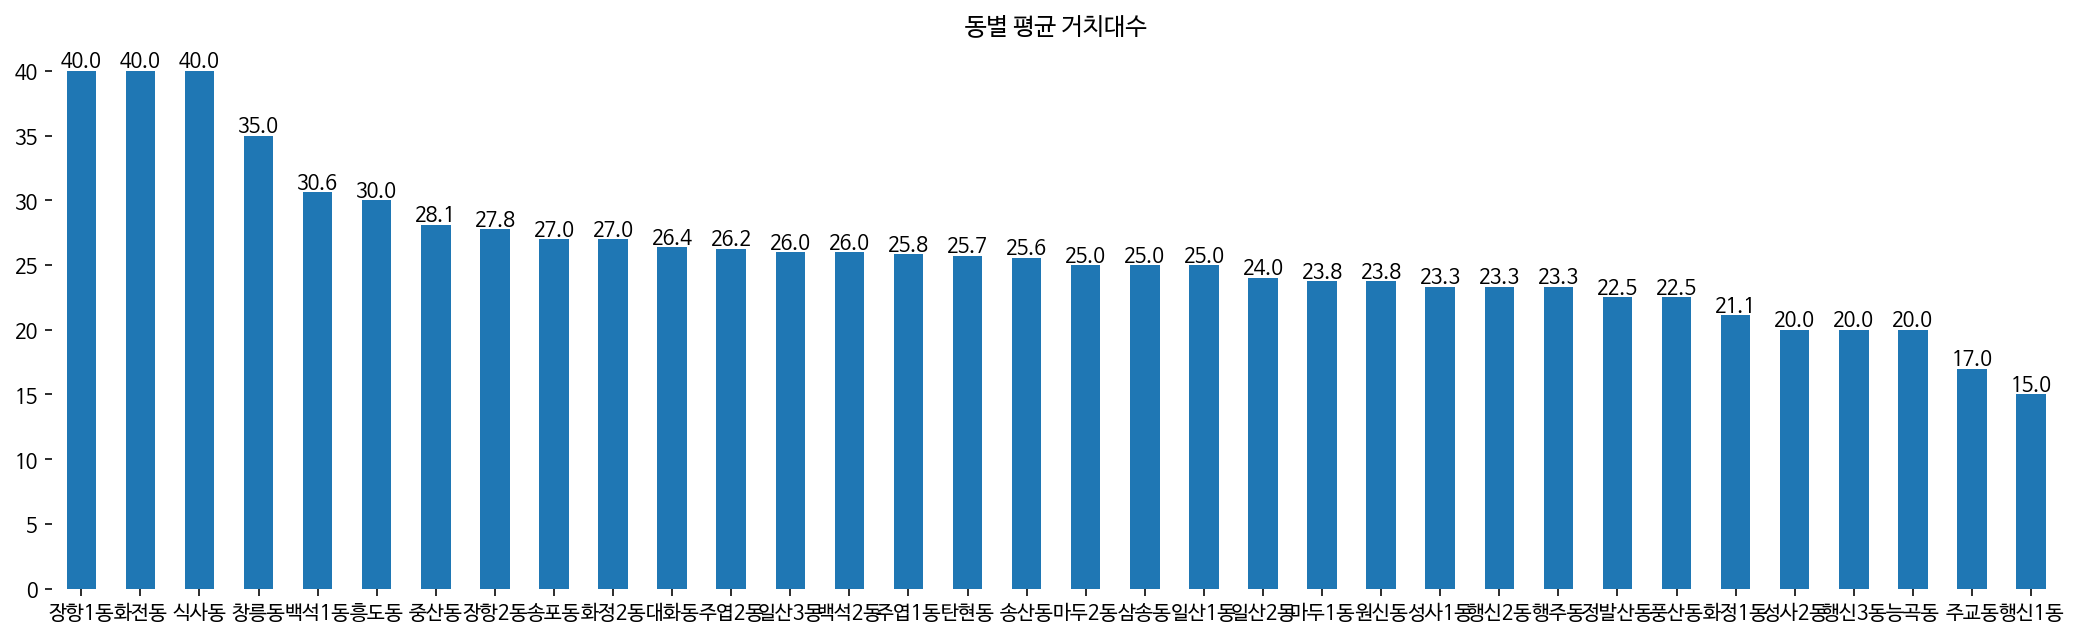

In [ ]:
bike_rental = station.groupby('dong')['거치대 수량'].sum()
bike_rental = bike_rental / dong_have_bikes
bike_rental.sort_values(ascending=False, inplace=True)

ax = bike_rental.plot(kind='bar', figsize=(18, 5), rot=0, title="동별 평균 거치대수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%.1f"%(height), (left+width/2, height+0.3), ha='center')
plt.box(False)
plt.xlabel("")
plt.show()

- Top 3
  - 장항1동: 2개의 스테이션 보유, 호수공원의 영향이 큰 것으로 보임
  - 화전동: 5개의 스테이션 보유, 덕양구 오른편 산 아래에 위치
  - 식사동: 2개의 스테이션 보유, 거주시설이 밀집되어 있는 구역에 위치한 것으로 보임


- Tail 3
  - 행신1동: 1개의 스테이션 보유, 동 면적 또한 좁음
  - 주교동: 1개의 스테이션 보유, 밀집 두 구역 사이에 위치
  - 능곡동: 1개의 스테이션 보유, 밀집 두 구역 사이에 위치
    - 주교동과 능곡동이 나란히 두 밀집구역을 나누는 지역임을 확인했다.
